## Name and ID

Irina Mengqi Wang
1278675 / mwang17

## HW03 Code


You will complete the following notebook, as described in the PDF for Homework 03 (included in the download with the starter code).  You will submit:
1. This notebook file, along with your COLLABORATORS.txt file, to the Gradescope link for code.
2. A PDF of this notebook and all of its output, once it is completed, to the Gradescope link for the PDF.


Please report any questions to the [class Piazza page](piazza.com/tufts/spring2021/comp135/home).

### Import required libraries

In [1]:
import os
import numpy as np
import pandas as pd

import warnings

import sklearn.linear_model
import sklearn.metrics

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn') # pretty matplotlib plots

In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)

Cancer-Risk Screening

### 1: Compute true/false positives/negatives.

Complete the following code.

In [3]:
def calc_TP_TN_FP_FN(ytrue_N, yhat_N):
    ''' Compute counts of four possible outcomes of a binary classifier for evaluation.
    
    Args
    ----
    ytrue_N : 1D array of floats
        Each entry represents the binary value (0 or 1) of 'true' label of one example
        One entry per example in current dataset
    yhat_N : 1D array of floats
        Each entry represents a predicted binary value (either 0 or 1).
        One entry per example in current dataset.
        Needs to be same size as ytrue_N.

    Returns
    -------
    TP : float
        Number of true positives
    TN : float
        Number of true negatives
    FP : float
        Number of false positives
    FN : float
        Number of false negatives
    '''
    TP = 0.0
    TN = 0.0
    FP = 0.0
    FN = 0.0
    
    for i in range(len(ytrue_N)):
        if (ytrue_N[i] == yhat_N[i] == 1):
            TP += 1
        elif (ytrue_N[i] == yhat_N[i] == 0):
            TN += 1
        elif (ytrue_N[i] == 0 and yhat_N[i] == 1):
            FP += 1
        else:
            FN += 1
    return TP, TN, FP, FN

In [4]:
all0 = np.zeros(10)
all1 = np.ones(10)
calc_TP_TN_FP_FN(all0, all1)

(0.0, 0.0, 10.0, 0.0)

In [5]:
calc_TP_TN_FP_FN(all1, all0)

(0.0, 0.0, 0.0, 10.0)

In [6]:
calc_TP_TN_FP_FN(all1, all1)

(10.0, 0.0, 0.0, 0.0)

In [7]:
calc_TP_TN_FP_FN(all0, all0)

(0.0, 10.0, 0.0, 0.0)

### Supplied functions for later use

***Do not*** edit the following functions.  They are already complete, and will be used in your later code.

In [8]:
def calc_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh):
    ''' Compute performance metrics for a given probabilistic classifier and threshold
    '''
    tp, tn, fp, fn = calc_TP_TN_FP_FN(ytrue_N, yproba1_N >= thresh)
    ## Compute ACC, TPR, TNR, etc.
    acc = (tp + tn) / float(tp + tn + fp + fn + 1e-10)
    tpr = tp / float(tp + fn + 1e-10)
    tnr = tn / float(fp + tn + 1e-10)
    ppv = tp / float(tp + fp + 1e-10)
    npv = tn / float(tn + fn + 1e-10)
    
    return acc, tpr, tnr, ppv, npv

def print_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh):
    ''' Pretty print perf. metrics for a given probabilistic classifier and threshold
    '''
    acc, tpr, tnr, ppv, npv = calc_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh)
    
    ## Pretty print the results
    print("%.3f ACC" % acc)
    print("%.3f TPR" % tpr)
    print("%.3f TNR" % tnr)
    print("%.3f PPV" % ppv)
    print("%.3f NPV" % npv)

In [9]:
def calc_confusion_matrix_for_threshold(ytrue_N, yproba1_N, thresh):
    ''' Compute the confusion matrix for a given probabilistic classifier and threshold
    
    Args
    ----
    ytrue_N : 1D array of floats
        Each entry represents the binary value (0 or 1) of 'true' label of one example
        One entry per example in current dataset
    yproba1_N : 1D array of floats
        Each entry represents a probability (between 0 and 1) that correct label is positive (1)
        One entry per example in current dataset
        Needs to be same size as ytrue_N
    thresh : float
        Scalar threshold for converting probabilities into hard decisions
        Calls an example "positive" if yproba1 >= thresh

    Returns
    -------
    cm_df : Pandas DataFrame
        Can be printed like print(cm_df) to easily display results
    '''
    cm = sklearn.metrics.confusion_matrix(ytrue_N, yproba1_N >= thresh)
    cm_df = pd.DataFrame(data=cm, columns=[0, 1], index=[0, 1])
    cm_df.columns.name = 'Predicted'
    cm_df.index.name = 'True'
    return cm_df

In [10]:
def compute_perf_metrics_across_thresholds(ytrue_N, yproba1_N, thresh_grid=None):
    ''' Compute common binary classifier performance metrics across many thresholds
    
    If no array of thresholds is provided, will use all 'unique' values
    in the yproba1_N array to define all possible thresholds with different performance.
    
    Args
    ----
    ytrue_N : 1D array of floats
        Each entry represents the binary value (0 or 1) of 'true' label of one example
        One entry per example in current dataset
    yproba1_N : 1D array of floats
        Each entry represents a probability (between 0 and 1) that correct label is positive (1)
        One entry per example in current dataset

    Returns
    -------
    thresh_grid : 1D array of floats
        One entry for each possible threshold
    perf_dict : dict, with key, value pairs:
        * 'acc' : 1D array of accuracy values (one per threshold)
        * 'ppv' : 1D array of positive predictive values (one per threshold)
        * 'npv' : 1D array of negative predictive values (one per threshold)
        * 'tpr' : 1D array of true positive rates (one per threshold)
        * 'tnr' : 1D array of true negative rates (one per threshold)
    '''
    if thresh_grid is None:
        bin_edges = np.linspace(0, 1.001, 21)
        thresh_grid = np.sort(np.hstack([bin_edges, np.unique(yproba1_N)]))
    tpr_grid = np.zeros_like(thresh_grid)
    tnr_grid = np.zeros_like(thresh_grid)
    ppv_grid = np.zeros_like(thresh_grid)
    npv_grid = np.zeros_like(thresh_grid)
    acc_grid = np.zeros_like(thresh_grid)
    for tt, thresh in enumerate(thresh_grid):
        # Apply specific threshold to convert probas into hard binary values (0 or 1)
        # Then count number of true positives, true negatives, etc.
        # Then compute metrics like accuracy and true positive rate
        acc, tpr, tnr, ppv, npv = calc_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh)
        acc_grid[tt] = acc
        tpr_grid[tt] = tpr
        tnr_grid[tt] = tnr
        ppv_grid[tt] = ppv
        npv_grid[tt] = npv
    return thresh_grid, dict(
        acc=acc_grid,
        tpr=tpr_grid,
        tnr=tnr_grid,
        ppv=ppv_grid,
        npv=npv_grid)

def make_plot_perf_vs_threshold(ytrue_N, yproba1_N, bin_edges=np.linspace(0, 1, 21)):
    ''' Make pretty plot of binary classifier performance as threshold increases
    
    Produces a plot with 3 rows:
    * top row: hist of predicted probabilities for negative examples (shaded red)
    * middle row: histogram of predicted probabilities for positive examples (shaded blue)
    * bottom row: line plots of metrics that require hard decisions (ACC, TPR, TNR, etc.)
    
    The two histograms are as follows:
    * The first (red) shows the number of class-0 entries, grouped by 
      the probabilities assigned by the predictor (yproba1_N).
    * The second (blue) shows the number of class-1 entries, grouped by
      the probabilities assigned by the predictor (yproba1_N).
    
    A "perfect" classifier would assign everything in class 0 the probability 0.0, 
    and everything in class 1 the probability 1.0, and the histograms would look 
    like one big pile of 150 items at 0.0, and then 25 items at 1.0.  
    
    You can actually see what this would look like by calling:
        make_plot_perf_vs_threshold(y_va_N, y_va_N)
    
    Note that we of course don't expect perfect (0.0/1.0) predictions, but we can 
    still get a "perfect" probabilistic classifier if we have a threshold point T 
    where all the 0-class stuff from the first histogram is below T, and all the 
    1-class stuff from the second one is at or above T.  Of course, we probably 
    can't get that either, since complex data may not be linearly separable at all, 
    but that's the goal.
    '''
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 8))
    sns.distplot(
        yproba1_N[ytrue_N == 0],
        color='r', bins=bin_edges, kde=False, rug=True, ax=axes[0]);
    sns.distplot(
        yproba1_N[ytrue_N == 1],
        color='b', bins=bin_edges, kde=False, rug=True, ax=axes[1]);

    thresh_grid, perf_grid = compute_perf_metrics_across_thresholds(ytrue_N, yproba1_N)
    axes[2].plot(thresh_grid, perf_grid['acc'], 'k-', label='accuracy')
    axes[2].plot(thresh_grid, perf_grid['tpr'], 'b-', label='TPR (recall/sensitivity)')
    axes[2].plot(thresh_grid, perf_grid['tnr'], 'g-', label='TNR (specificity)')
    axes[2].plot(thresh_grid, perf_grid['ppv'], 'c-', label='PPV (precision)')
    axes[2].plot(thresh_grid, perf_grid['npv'], 'm-', label='NPV')
    
    axes[2].legend()
    axes[2].set_ylim([0, 1])

### Load the dataset.

The following should ***not*** be modified.  After it runs, the various arrays it creates will contain the 2- or 3-feature input datasets.

In [11]:
# Load 3 feature version of x arrays
x_tr_M3 = np.loadtxt('./data_cancer/x_train.csv', delimiter=',', skiprows=1)
x_va_N3 = np.loadtxt('./data_cancer/x_valid.csv', delimiter=',', skiprows=1)
x_te_N3 = np.loadtxt('./data_cancer/x_test.csv', delimiter=',', skiprows=1)

# 2 feature version of x arrays
x_tr_M2 = x_tr_M3[:, :2].copy()
x_va_N2 = x_va_N3[:, :2].copy()
x_te_N2 = x_te_N3[:, :2].copy()

In [12]:
y_tr_M = np.loadtxt('./data_cancer/y_train.csv', delimiter=',', skiprows=1)
y_va_N = np.loadtxt('./data_cancer/y_valid.csv', delimiter=',', skiprows=1)
y_te_N = np.loadtxt('./data_cancer/y_test.csv', delimiter=',', skiprows=1)

### 2: Compute the fraction of patients with cancer.

Complete the following code.  Your solution needs to ***compute*** these values from the training, validation, and testing sets (i.e., don't simply hand-count and print the values).

In [13]:
print("Fraction with cancer in TRAIN: %.3f" % (len(np.nonzero(y_tr_M)[0])/len(y_tr_M))) 
print("Fraction with cancer in VALID: %.3f" % (len(np.nonzero(y_va_N)[0])/len(y_va_N)))
print("Fraction with cancer in TEST : %.3f" % (len(np.nonzero(y_te_N)[0])/len(y_te_N)))

Fraction with cancer in TRAIN: 0.141
Fraction with cancer in VALID: 0.139
Fraction with cancer in TEST : 0.139


### 3: The predict-0-always baseline

#### (a) Compute the accuracy of the always-0 classifier.

Complete the code to compute and print the accuracy of the always-0 classifier on validation and test outputs.

In [14]:
always_0_va_acc, _, _, _, _ = calc_perf_metrics_for_threshold(y_va_N, np.zeros(len(y_va_N)), 0.5)
always_0_te_acc, _, _, _, _ = calc_perf_metrics_for_threshold(y_te_N, np.zeros(len(y_te_N)), 0.5)

print("Always-0: accuracy on VALID: %.3f" % always_0_va_acc) # TODO edit values!
print("Always-0: accuracy on TEST : %.3f" % always_0_te_acc)


Always-0: accuracy on VALID: 0.861
Always-0: accuracy on TEST : 0.861


#### (b) Print a confusion matrix for the always-0 classifier.

Add code below to generate a confusion matrix for the always-0 classifier on the validation set.

In [15]:
y_va_pred_all_zeros = np.zeros(len(y_va_N))
print(calc_confusion_matrix_for_threshold(y_va_N, y_va_pred_all_zeros, 0.5))

Predicted    0  1
True             
0          155  0
1           25  0


#### (c) Reflect on the accuracy of the always-0 classifier.

**Answer**: 

The higher accuracy rate is mainly due to the low cancer proportion in the population and in reality. 

**[+]**
- High overall accuracy, as there are statistically more negative cases in the populaton(the true negative rate is 100%). 
- it's simple, and it's easy to generate and calculate.
- no need to fit a model to do the prediction, and helps us achieve our goal of avoiding painful biopsy.


**[-]**
- it fails to explain the relationship of the outputs in relationship to the features.
- And people who actually have cancer will never be diagnosed.
- it reflects the proportion of negative case in the sample and it's _always_ 0, the predicting performance might be relatively low on other data. 

#### (d) Analyze the various costs of using the always-0 classifier.


Although this always-0 classifier help us generate high _correct rejection_ on all actual negative cases, it's also being overly positive and will _miss_ the patients who actually have cancer. In other words, it will also contain **high false negatives** which often come at a great cost---- patient may miss the "golden window" and even pay with their lives, not to the psychological suffering and late surgery fees. Hospital, on the other hand, may be sued for the diagnosis failure and experience a lost in reputation. These are pretty serious consequences, sometimes even worse than saying everyone has cancer with the always-1 classifier. Thus in general, I would not to use this classifier.

### 4: Logistic Regression

#### (a) Create a set of `LogisticRegression` models.

Each model will use a different control parameter, `C`, and each will be fit to 2-feature data.  Probabilistic predictions will be made on both **training set** and **validation set** inputs, and logistic-loss for each will be recorded.

In [16]:
tr_loss_list = list()
va_loss_list = list()

N2_model_list = list()
C_grid = np.logspace(-9, 6, 31)
for C in C_grid:
    model = sklearn.linear_model.LogisticRegression(C=C,solver='liblinear')
    model.fit(x_tr_M2,y_tr_M)
    
    N2_model_list.append(model)
    p_tr = model.predict_proba(x_tr_M2)
    p_va = model.predict_proba(x_va_N2)

    tr_log_loss = sklearn.metrics.log_loss(y_tr_M,p_tr)
    va_log_loss = sklearn.metrics.log_loss(y_va_N,p_va)
    
    tr_loss_list.append(tr_log_loss)
    va_loss_list.append(va_log_loss)

In [17]:
# print out the results in clear tabular format
pd.DataFrame(np.transpose([tr_loss_list, va_loss_list]), columns=['2 feature train loss', '2 feature validation loss'])

,2 feature train loss,2 feature validation loss
0,0.692946,0.692942
1,0.692510,0.692500
2,0.691142,0.691110
3,0.686890,0.686790
4,0.674156,0.673852
5,0.639965,0.639109
6,0.570698,0.568692
7,0.489034,0.485551
8,0.440997,0.436387
9,0.426297,0.421078


In [18]:
min_loss = min(va_loss_list)
index_N2 = va_loss_list.index(min_loss)
best_C =  C_grid[index_N2]

#### Plot logistic loss (y-axis) vs. C (x-axis) on the training set and validation set.

The best values for `C` and the loss should be printed.

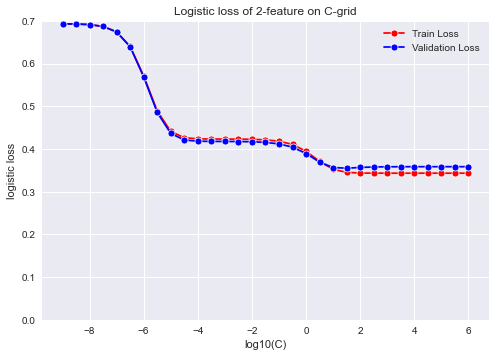

Best C-value for LR with 2-feature data: 31.623
Validation set log-loss at best C-value: 0.3549


In [19]:
plt.xlabel('log10(C)');
plt.ylabel('logistic loss');
plt.ylim([0.0, 0.7]);

sns.lineplot(x = np.log10(C_grid), y = tr_loss_list, label = "Train Loss", color = "red", marker='o')
sns.lineplot(x = np.log10(C_grid), y = va_loss_list,label = "Validation Loss", color = "blue", marker='o')

# show a legend on the plot 
plt.legend() 
plt.title('Logistic loss of 2-feature on C-grid')
plt.show()

print("Best C-value for LR with 2-feature data: %.3f" % best_C) 
print("Validation set log-loss at best C-value: %.4f" % min_loss)

#### (b) Plot the performance of the predictions made by the best classifier from step (a) on the validation set.

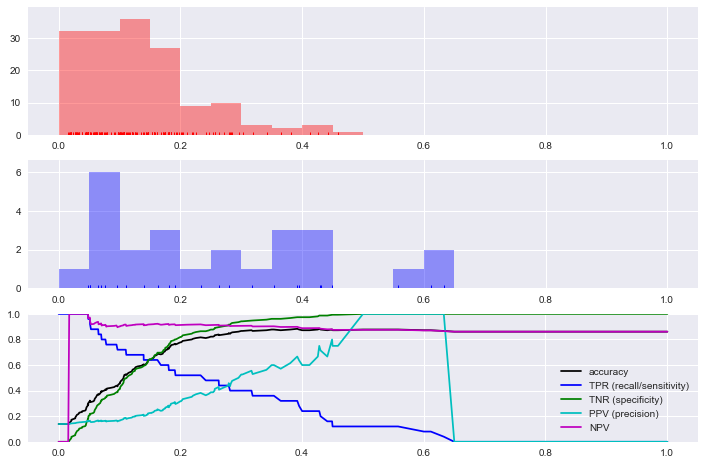

In [20]:
best_model_N2 = N2_model_list[index_N2]
yprob_va_N2 = best_model_N2.predict_proba(x_va_N2)
make_plot_perf_vs_threshold(y_va_N, yprob_va_N2[:, 1],bin_edges=np.linspace(0, 1, 21))

#### (c) Model fitting with 3-feature data

Repeat the model generation from **1.4 (a)**, using the full 3-feature data.

In [21]:
tr_loss_list = list()
va_loss_list = list()
N3_model_list = list()

C_grid = np.logspace(-9, 6, 31)
for C in C_grid:
    model = sklearn.linear_model.LogisticRegression(C=C,solver='liblinear')
    model.fit(x_tr_M3,y_tr_M)
    
    N3_model_list.append(model)
    p_tr = model.predict_proba(x_tr_M3)
    p_va = model.predict_proba(x_va_N3)

    tr_log_loss = sklearn.metrics.log_loss(y_tr_M,p_tr)
    va_log_loss = sklearn.metrics.log_loss(y_va_N,p_va)
    
    tr_loss_list.append(tr_log_loss)
    va_loss_list.append(va_log_loss)

In [22]:
# print out the results in clear tabular format
pd.DataFrame(np.transpose([tr_loss_list, va_loss_list]), columns=['3 features train loss', '3 features validation loss'])

,3 features train loss,3 features validation loss
0,0.692946,0.692942
1,0.692510,0.692500
2,0.691142,0.691110
3,0.686889,0.686789
4,0.674154,0.673850
5,0.639960,0.639104
6,0.570692,0.568688
7,0.489036,0.485555
8,0.440993,0.436381
9,0.426229,0.420993


In [23]:
min_loss_N3 = min(va_loss_list)
index_N3 = va_loss_list.index(min_loss_N3)
best_C_N3 =  C_grid[index_N3]

#### Plot logistic loss (y-axis) vs. C (x-axis) for the 3-feature classifiers on the training set and validation set.

Again, the best values for `C` and the loss should be printed.

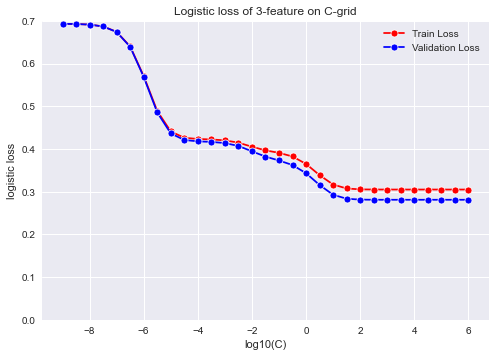

Best C-value for LR with 2-feature data: 1000000.000
Validation set log-loss at best C-value: 0.2810


In [24]:
plt.xlabel('log10(C)');
plt.ylabel('logistic loss');
plt.ylim([0.0, 0.7]);

sns.lineplot(x = np.log10(C_grid), y = tr_loss_list, label = "Train Loss", color = "red", marker='o')
sns.lineplot(x = np.log10(C_grid), y = va_loss_list,label = "Validation Loss", color = "blue", marker='o')

# show a legend on the plot 
plt.legend() 
plt.title('Logistic loss of 3-feature on C-grid')
plt.show()

print("Best C-value for LR with 2-feature data: %.3f" % best_C_N3) 
print("Validation set log-loss at best C-value: %.4f" % min_loss_N3)

#### Plot the performance of the predictions made by the best 3-valued classifier on the validation set.

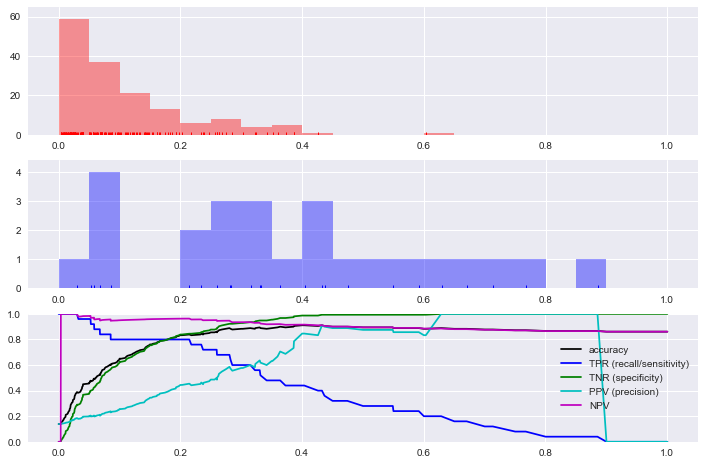

In [25]:
best_model_N3 = N3_model_list[index_N3]
yprob_va_N3 = best_model_N3.predict_proba(x_va_N3)
make_plot_perf_vs_threshold(y_va_N, yprob_va_N3[:, 1],bin_edges=np.linspace(0, 1, 21))

### 5: ROC Curves

These curves allow us to compare model performance in terms of trade-offs between false positive and true positive results.

#### (a) Plot ROC curves on the validation set.

There should be two curves in the plot, one for each of the best two classifiers from prior steps.

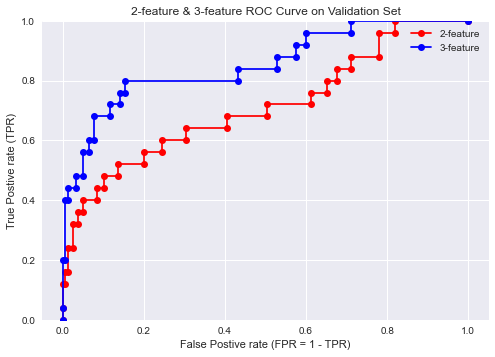

In [26]:
fpr_va_N2, tpr_va_N2, thr_N2 = sklearn.metrics.roc_curve(y_va_N, yprob_va_N2[:, 1])
fpr_va_N3, tpr_va_N3, thr_N3 = sklearn.metrics.roc_curve(y_va_N, yprob_va_N3[:, 1])

plt.ylim([0, 1]);
plt.xlabel("False Postive rate (FPR = 1 - TPR)")
plt.ylabel("True Postive rate (TPR)")

plt.plot(fpr_va_N2, tpr_va_N2, label = "2-feature", color = "red", marker='o')
plt.plot(fpr_va_N3, tpr_va_N3, label = "3-feature", color = "blue", marker='o')

# show a legend on the plot 
plt.legend() 
plt.title("2-feature & 3-feature ROC Curve on Validation Set")
plt.show()

#### (b) Plot ROC curves on the test set.

There should be two curves in the plot, one for each of the best two classifiers from prior steps.

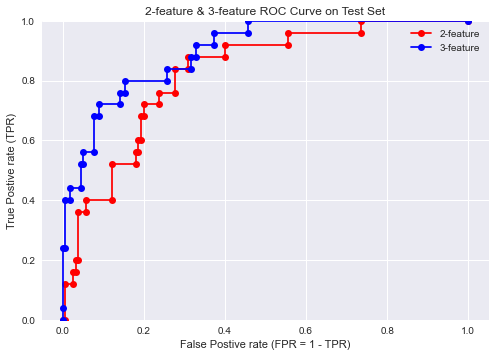

In [27]:
yprob_te_N2 = best_model_N2.predict_proba(x_te_N2)
yprob_te_N3 = best_model_N3.predict_proba(x_te_N3)

fpr_te_N2, tpr_te_N2, thr = sklearn.metrics.roc_curve(y_te_N, yprob_te_N2[:, 1])
fpr_te_N3, tpr_te_N3, thr = sklearn.metrics.roc_curve(y_te_N, yprob_te_N3[:, 1])

plt.ylim([0, 1]);
plt.xlabel("False Postive rate (FPR = 1 - TPR)");
plt.ylabel("True Postive rate (TPR)");

plt.plot(fpr_te_N2, tpr_te_N2, label = "2-feature", color = "red", marker='o')
plt.plot(fpr_te_N3, tpr_te_N3, label = "3-feature", color = "blue", marker='o')

# show a legend on the plot 
plt.legend() 
plt.title("2-feature & 3-feature ROC Curve on Test Set")
plt.show()

#### (c) Analyze the results shown in both the above plots, to compare classifier performance.

**Answer**:

Analyze the results to compare the two models, over both data sets. Does one dominate the other in terms of overall performance, or are there areas where one model “wins” and others where the other model does? What does this tell you?

Both validation and test set show larger AUROC for 3-feature classifiers, so 3 feature classifiers dominate 2 feature classifiers in terms of overall performance. Although there are cross-overs indicating rarely 2-feature does generates better results at some threshold, overall this trend indicates that using the 3 features are better at predicting 2 features. 


### 6: Selecting a decision threshold

#### (a) Using default 0.5 threshold. 

Generate a confusion matrix for the best 3-feature logistic model on the test set, using threshold 0.5.

In [28]:
best_thr = 0.5

print("Chosen best thr = %.4f" % best_thr)
print("")
print("ON THE TEST SET:")
print(calc_confusion_matrix_for_threshold(y_te_N, yprob_te_N3[:,1], best_thr))
print("")
print_perf_metrics_for_threshold(y_te_N, yprob_te_N3[:,1], best_thr)

Chosen best thr = 0.5000

ON THE TEST SET:
Predicted    0   1
True              
0          152   3
1           15  10

0.900 ACC
0.400 TPR
0.981 TNR
0.769 PPV
0.910 NPV


#### (b) Pick a threshold to maximize TPR, while ensuring PPV >= 0.98.

After finding the best threshold on the validation set, plot its confusion matrix and print its various performance metrics, for the test set.

In [29]:
thresh_grid, perf_grid = compute_perf_metrics_across_thresholds(y_va_N, yprob_va_N3[:,1])
perf_grid

qualified_index = np.argwhere(perf_grid['ppv'] >= 0.98)
filtered_tpr = perf_grid['tpr'][qualified_index]

max_tpr = np.argmax(filtered_tpr)
best_i = qualified_index[max_tpr]
best_thr = thresh_grid[best_i] 

print("ON THE VALIDATION SET:")
print("Chosen best thr = %.4f" % best_thr)
print("")
print("ON THE TEST SET:")
print(calc_confusion_matrix_for_threshold(y_te_N, yprob_te_N3[:,1], best_thr))
print("")
print_perf_metrics_for_threshold(y_te_N, yprob_te_N3[:,1], best_thr)

ON THE VALIDATION SET:
Chosen best thr = 0.6290

ON THE TEST SET:
Predicted    0  1
True             
0          155  0
1           20  5

0.889 ACC
0.200 TPR
1.000 TNR
1.000 PPV
0.886 NPV


#### (c) Pick a threshold to maximize PPV, while ensuring TPR >= 0.98.

After finding the best threshold on the validation set, plot its confusion matrix and print its various performance metrics, for the test set.

In [30]:
thresh_grid, perf_grid = compute_perf_metrics_across_thresholds(y_va_N, yprob_va_N3[:,1])
perf_grid

qualified_index = np.argwhere(perf_grid['tpr'] >= 0.98)
filtered_ppv = perf_grid['ppv'][qualified_index]

max_ppv = np.argmax(filtered_ppv)
best_i = qualified_index[max_ppv]
best_thr = thresh_grid[best_i] 


print("ON THE VALIDATION SET:")
print("Chosen best thr = %.4f" % best_thr) 
print("")
print("ON THE TEST SET:")
print(calc_confusion_matrix_for_threshold(y_te_N, yprob_te_N3[:,1], best_thr))
print("")
print_perf_metrics_for_threshold(y_te_N, yprob_te_N3[:,1], best_thr)

ON THE VALIDATION SET:
Chosen best thr = 0.0300

ON THE TEST SET:
Predicted   0   1
True             
0          57  98
1           0  25

0.456 ACC
1.000 TPR
0.368 TNR
0.203 PPV
1.000 NPV


#### (d) Compare the confusion matrices from (a)–(c) to analyze the different thresholds.

**Answer**: 


Life-threatening mistakes are those predicted negative while the patient actually have cancer(false negative). If we want to avoid life-threatening mistakes at all costs, we should choose the threshold at 0.03, which maximize PPV, while ensuring TPR >= 0.98. In this way, we can also eliminate unnecessary biopsy operations.  


#### (e) How many biopsies can be avoided using the best threshold for the classifier?

**Answer**: If we were to use the threshold at 0.03, we can save 57 people who are true negatives from unnecessary biopsy operations. That is, 57/(57+98+25) = 31.67% of the people can avoid biopsies if this classifier were used by the hospital.